In [10]:
!nvidia-smi

Sun Feb  4 22:12:25 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.147.05   Driver Version: 525.147.05   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:62:00.0 Off |                    0 |
| N/A   38C    P0    44W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [11]:
import torch
import pandas as pd
from transformers import AutoTokenizer, DataCollatorForLanguageModeling, GPT2LMHeadModel, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict
from evaluate import load
from torch.utils.data import DataLoader
from torch import nn, optim
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from torch.nn import DataParallel
from math import nan

In [12]:
pd.set_option('display.max_colwidth', None)

In [13]:
train_df = pd.read_csv("data/sbic/SBIC.v2.trn.csv")
valid_df = pd.read_csv("data/sbic/SBIC.v2.dev.csv")
test_df = pd.read_csv("data/sbic/SBIC.v2.tst.csv")

print("Shapes of dataframes")
print(f"Training file: {train_df.shape}")
print(f"Validation file: {valid_df.shape}")
print(f"Test Shape: {test_df.shape}")

Shapes of dataframes
Training file: (112900, 19)
Validation file: (16738, 19)
Test Shape: (17501, 19)


In [14]:
model_checkpoint = 'gpt2'
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)
tokenizer.sep_token = '[SEP]'
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = 'left'

In [15]:
train_df.isna().sum()

whoTarget             46931
intentYN                  0
sexYN                     0
sexReason            102520
offensiveYN            2017
annotatorGender           1
annotatorMinority     83870
sexPhrase            102507
speakerMinorityYN     67437
WorkerId                  0
HITId                     0
annotatorPolitics         1
annotatorRace             1
annotatorAge              1
post                      0
targetMinority        70406
targetCategory        70406
targetStereotype      71192
dataSource                0
dtype: int64

In [16]:
race_mapping = {'white': '[WHITE]',
                    'hisp': '[HISPANIC]',
                    'asian': '[ASIAN]',
                    'other': '[OTHER]',
                    'black': '[BLACK]',
                    'native': '[NATIVE]',
                    'na': '[OTHER]'}
train_df['mapped_race'] = train_df['annotatorRace'].map(race_mapping)
valid_df['mapped_race'] = valid_df['annotatorRace'].map(race_mapping)
test_df['mapped_race'] = test_df['annotatorRace'].map(race_mapping)

In [17]:
politics_mapping = {'liberal': '[LIBERAL]',
                    'mod-liberal': '[MODERATE]',
                    'mod-cons': '[MODERATE]',
                    'other': '[OTHER]',
                    'cons': '[CONSERVATIVE]',
                    'libert': '[LIBERT]',
                    'na': '[OTHER]'}
train_df['mapped_politics'] = train_df['annotatorPolitics'].map(politics_mapping)
valid_df['mapped_politics'] = valid_df['annotatorPolitics'].map(politics_mapping)
test_df['mapped_politics'] = test_df['annotatorPolitics'].map(politics_mapping)

In [18]:
gender_mapping = {'woman': '[FEMALE]',
                  'man': '[MALE]',
                  'na': '[NAN]',
                  'nonBinary': '[NONBIN]',
                  'transman': '[TRANS]'}
train_df['mapped_gender'] = train_df['annotatorGender'].map(gender_mapping)
valid_df['mapped_gender'] = valid_df['annotatorGender'].map(gender_mapping)
test_df['mapped_gender'] = test_df['annotatorGender'].map(gender_mapping)
train_df.head(2)

,whoTarget,intentYN,sexYN,sexReason,offensiveYN,annotatorGender,annotatorMinority,sexPhrase,speakerMinorityYN,WorkerId,...,annotatorRace,annotatorAge,post,targetMinority,targetCategory,targetStereotype,dataSource,mapped_race,mapped_politics,mapped_gender
0,0.0,0.66,0.0,NaN,1.0,woman,NaN,NaN,NaN,-8935932304856669427,...,white,45.0,"RT @_LexC__: I'm convinced that some of y'all bitches get pregnant purposely because ""birth control &amp; plan b pills"" are effective &#128533;&#128056;&#9749;&#65039;",NaN,NaN,NaN,t/davidson,[WHITE],[LIBERAL],[FEMALE]
1,0.0,0.66,0.0,NaN,0.5,man,NaN,NaN,NaN,6347880360297734464,...,white,35.0,"RT @_LexC__: I'm convinced that some of y'all bitches get pregnant purposely because ""birth control &amp; plan b pills"" are effective &#128533;&#128056;&#9749;&#65039;",NaN,NaN,NaN,t/davidson,[WHITE],[MODERATE],[MALE]


In [21]:
def dataframe_preprocess(df):
    df['worker'] = df['WorkerId'].apply(lambda x:f"[Worker_{x}]") # create tokens for each unique worker in format Worker_{worker_id}
    df['offensive'] = df['offensiveYN'].apply(lambda x:'[OFF_N]' if x<0.5 else '[OFF_Y]')
    df['lewd'] = df['sexYN'].apply(lambda x:'[SEX_N]' if x<0.5 else '[SEX_Y]')
    df['intent'] = df['intentYN'].apply(lambda x:'[INTENT_N]' if x<0.5 else '[INTENT_Y]')
    df['category'] = df['targetCategory'].apply(lambda x: '[CAT_Y]' if pd.notna(x) else '[CAT_N]')
    df['minority'] = df['targetMinority'].apply(lambda x: '[MIN_Y]' if pd.notna(x) else '[MIN_N]')
    df['text_prefix'] = df.apply(lambda row: f"{row['worker']} is {row['annotatorRace']}, {row['annotatorPolitics']} and {row['annotatorGender']}.", axis=1)

    #df['group'] = df['whoTarget'].apply(lambda x: '[GRP_N]' if x<0.5 else '[GRP_Y]')

    selected_columns = ['post', 'worker', 'offensive', 'lewd', 'intent', 'category', 'minority', 'mapped_gender', 'mapped_politics', 'mapped_race', 'text_prefix']
    df = df[selected_columns]
    
    # create feature column
    train_text = lambda x: ' '.join([str(x['text_prefix']), tokenizer.sep_token, str(x['post']), tokenizer.sep_token, str(x['offensive']),
                                     str(x['lewd']), str(x['intent']), str(x['category']), str(x['minority'])]) 
    df['train_text'] = df.apply(train_text, axis=1)
    
    test_text = lambda x: ' '.join([str(x['text_prefix']), tokenizer.sep_token, str(x['post']), tokenizer.sep_token])    
    df['test_text'] = df.apply(test_text, axis=1)

    return df

In [22]:
train_data = dataframe_preprocess(train_df)
valid_data = dataframe_preprocess(valid_df)
test_data = dataframe_preprocess(test_df)

/w0/tmp/slurm_ky362276.43222080/ipykernel_49649/2262844877.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['train_text'] = df.apply(train_text, axis=1)
/w0/tmp/slurm_ky362276.43222080/ipykernel_49649/2262844877.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['test_text'] = df.apply(test_text, axis=1)
/w0/tmp/slurm_ky362276.43222080/ipykernel_49649/2262844877.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

In [23]:
train_data.shape

(112900, 13)

In [24]:
train_data.dropna(inplace=True)

/w0/tmp/slurm_ky362276.43222080/ipykernel_49649/1654660196.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.dropna(inplace=True)


In [25]:
train_data.shape

(112899, 13)

In [26]:
print(f"Current length of tokenizer: {len(tokenizer)}")

Current length of tokenizer: 50257


In [27]:
train_data.head()

,post,worker,offensive,lewd,intent,category,minority,mapped_gender,mapped_politics,mapped_race,text_prefix,train_text,test_text
0,"RT @_LexC__: I'm convinced that some of y'all bitches get pregnant purposely because ""birth control &amp; plan b pills"" are effective &#128533;&#128056;&#9749;&#65039;",[Worker_-8935932304856669427],[OFF_Y],[SEX_N],[INTENT_Y],[CAT_N],[MIN_N],[FEMALE],[LIBERAL],[WHITE],"[Worker_-8935932304856669427] is white, liberal and woman.","[Worker_-8935932304856669427] is white, liberal and woman. [SEP] RT @_LexC__: I'm convinced that some of y'all bitches get pregnant purposely because ""birth control &amp; plan b pills"" are effective &#128533;&#128056;&#9749;&#65039; [SEP] [OFF_Y] [SEX_N] [INTENT_Y] [CAT_N] [MIN_N]","[Worker_-8935932304856669427] is white, liberal and woman. [SEP] RT @_LexC__: I'm convinced that some of y'all bitches get pregnant purposely because ""birth control &amp; plan b pills"" are effective &#128533;&#128056;&#9749;&#65039; [SEP]"
1,"RT @_LexC__: I'm convinced that some of y'all bitches get pregnant purposely because ""birth control &amp; plan b pills"" are effective &#128533;&#128056;&#9749;&#65039;",[Worker_6347880360297734464],[OFF_Y],[SEX_N],[INTENT_Y],[CAT_N],[MIN_N],[MALE],[MODERATE],[WHITE],"[Worker_6347880360297734464] is white, mod-liberal and man.","[Worker_6347880360297734464] is white, mod-liberal and man. [SEP] RT @_LexC__: I'm convinced that some of y'all bitches get pregnant purposely because ""birth control &amp; plan b pills"" are effective &#128533;&#128056;&#9749;&#65039; [SEP] [OFF_Y] [SEX_N] [INTENT_Y] [CAT_N] [MIN_N]","[Worker_6347880360297734464] is white, mod-liberal and man. [SEP] RT @_LexC__: I'm convinced that some of y'all bitches get pregnant purposely because ""birth control &amp; plan b pills"" are effective &#128533;&#128056;&#9749;&#65039; [SEP]"
2,"RT @_LexC__: I'm convinced that some of y'all bitches get pregnant purposely because ""birth control &amp; plan b pills"" are effective &#128533;&#128056;&#9749;&#65039;",[Worker_-7452610791699819066],[OFF_Y],[SEX_N],[INTENT_N],[CAT_N],[MIN_N],[MALE],[LIBERAL],[ASIAN],"[Worker_-7452610791699819066] is asian, liberal and man.","[Worker_-7452610791699819066] is asian, liberal and man. [SEP] RT @_LexC__: I'm convinced that some of y'all bitches get pregnant purposely because ""birth control &amp; plan b pills"" are effective &#128533;&#128056;&#9749;&#65039; [SEP] [OFF_Y] [SEX_N] [INTENT_N] [CAT_N] [MIN_N]","[Worker_-7452610791699819066] is asian, liberal and man. [SEP] RT @_LexC__: I'm convinced that some of y'all bitches get pregnant purposely because ""birth control &amp; plan b pills"" are effective &#128533;&#128056;&#9749;&#65039; [SEP]"
3,RT @iBeZo: Stupid fucking nigger LeBron. You flopping stupid jungle bunny monkey faggot.,[Worker_-500114755446676507],[OFF_Y],[SEX_N],[INTENT_Y],[CAT_Y],[MIN_Y],[MALE],[LIBERAL],[WHITE],"[Worker_-500114755446676507] is white, liberal and man.","[Worker_-500114755446676507] is white, liberal and man. [SEP] RT @iBeZo: Stupid fucking nigger LeBron. You flopping stupid jungle bunny monkey faggot. [SEP] [OFF_Y] [SEX_N] [INTENT_Y] [CAT_Y] [MIN_Y]","[Worker_-500114755446676507] is white, liberal and man. [SEP] RT @iBeZo: Stupid fucking nigger LeBron. You flopping stupid jungle bunny monkey faggot. [SEP]"
4,RT @iBeZo: Stupid fucking nigger LeBron. You flopping stupid jungle bunny monkey faggot.,[Worker_-500114755446676507],[OFF_Y],[SEX_N],[INTENT_Y],[CAT_Y],[MIN_Y],[MALE],[LIBERAL],[WHITE],"[Worker_-500114755446676507] is white, liberal and man.","[Worker_-500114755446676507] is white, liberal and man. [SEP] RT @iBeZo: Stupid fucking nigger LeBron. You flopping stupid jungle bunny monkey faggot. [SEP] [OFF_Y] [SEX_N] [INTENT_Y] [CAT_Y] [MIN_Y]","[Worker_-500114755446676507] is white, liberal and man. [SEP] RT @iBeZo: Stupid fucking nigger LeBron. You flopping stupid jungle bunny monkey faggot. [SEP]"


In [30]:
# new tokens
offensive_tokens = list(train_data['offensive'].unique())
lewd_tokens = list(train_data['lewd'].unique())
intent_tokens = list(train_data['intent'].unique())
category_tokens = list(train_data['category'].unique())
minority_tokens = list(train_data['minority'].unique())
worker_tokens = list(train_data['worker'].unique())
#group_tokens = list(train_data['group'].unique())
#gender_tokens = list(train_data['mapped_gender'].unique())
#politics_tokens = list(train_data['mapped_politics'].unique())
#race_tokens = list(train_data['mapped_race'].unique())

new_tokens = offensive_tokens + lewd_tokens + intent_tokens + category_tokens + minority_tokens + worker_tokens
print(len(new_tokens))

273


In [31]:
train_data.shape

(112899, 13)

In [32]:
tokenizer.add_tokens(new_tokens)
print(f"Final size of tokenizer: {len(tokenizer)}")

Final size of tokenizer: 50530


In [33]:
train_dataset = Dataset.from_pandas(train_data)
valid_dataset = Dataset.from_pandas(valid_data)
test_dataset = Dataset.from_pandas(test_data)

In [34]:
def tokenize_train(example):
    return tokenizer(example['train_text'], max_length=128, padding='max_length', truncation=True)

def tokenize_test(example):
    return tokenizer(example['test_text'], max_length=128, padding='max_length', truncation=True)

In [35]:
tokenized_train = train_dataset.map(tokenize_train, batched=True)
tokenized_train = tokenized_train.remove_columns(['post', 'worker', 'offensive', 'lewd', 'intent', 'category', 'minority', 'train_text',
                                                  'test_text', 'mapped_gender', 'mapped_politics', 'mapped_race', 'text_prefix', '__index_level_0__'])
tokenized_train.set_format('torch')
tokenized_train

Map:   0%|          | 0/112899 [00:00<?, ? examples/s]

Dataset({
    features: ['input_ids', 'attention_mask'],
    num_rows: 112899
})

In [37]:
tokenized_valid = valid_dataset.map(tokenize_train, batched=True)
tokenized_valid = tokenized_valid.remove_columns(['post', 'worker', 'offensive', 'lewd', 'intent', 'category', 'minority',
                                                  'train_text', 'test_text', 'mapped_gender', 'mapped_politics', 'mapped_race', 'text_prefix'])
tokenized_valid.set_format('torch')
tokenized_valid

Map:   0%|          | 0/16738 [00:00<?, ? examples/s]

Dataset({
    features: ['input_ids', 'attention_mask'],
    num_rows: 16738
})

In [38]:
tokenized_test = test_dataset.map(tokenize_test, batched=True)
tokenized_test = tokenized_test.remove_columns(['post', 'worker', 'offensive', 'lewd', 'intent', 'category', 'minority', 'train_text',
                                                'test_text', 'mapped_gender', 'mapped_politics', 'mapped_race', 'text_prefix'])
tokenized_test.set_format('torch')
tokenized_test

Map:   0%|          | 0/17501 [00:00<?, ? examples/s]

Dataset({
    features: ['input_ids', 'attention_mask'],
    num_rows: 17501
})

In [39]:
batch_size = 16

data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

train_dataloader = DataLoader(tokenized_train, batch_size=batch_size, shuffle=True, collate_fn=data_collator)
valid_dataloader = DataLoader(tokenized_valid, batch_size=batch_size, collate_fn=data_collator)
test_dataloader = DataLoader(tokenized_test, batch_size=batch_size, collate_fn=data_collator)

In [40]:
model = GPT2LMHeadModel.from_pretrained(model_checkpoint)
model.resize_token_embeddings(len(tokenizer))
model_size = sum(t.numel() for t in model.parameters())
print(f"GPT-2 size: {model_size/1000**2:.1f}M parameters")

GPT-2 size: 124.6M parameters


In [41]:
num_epochs = 5
learning_rate = 5e-5
epsilon = 1e-8
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, eps=epsilon)
total_steps = len(train_dataloader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

In [42]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50530, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dro

In [43]:
def validate_model(dataloader, model, device):
    model.eval()
    valid_loss = 0

    for batch in dataloader:
        batch = {k:v.type(torch.long).to(device) for k,v in batch.items()}
        input_ids, attention_mask, labels = batch['input_ids'], batch['attention_mask'], batch['input_ids']

        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            #predictions = outputs.logits.view(-1, outputs.logits.size(-1))
            #labels = labels.view(-1)
            #loss = criterion(predictions, labels)
            loss = outputs.loss
            valid_loss += loss.item()

    valid_loss /= len(dataloader)

    return valid_loss

In [44]:
def train_model(train_dataloader, valid_dataloader, model, optimizer, scheduler, num_epochs, device):
    progress_bar = tqdm(range(len(train_dataloader) * num_epochs))
    train_losses = []
    valid_losses = []
    best_epoch = -1
    best_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0

        for batch in train_dataloader:
            batch = {k:v.type(torch.long).to(device) for k,v in batch.items()}
            input_ids, attention_mask, labels = batch['input_ids'], batch['attention_mask'], batch['input_ids']

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs[0]
            train_loss += loss.item()

            loss.backward()
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
            progress_bar.update(1)

        train_loss /= len(train_dataloader)
        train_losses.append(train_loss)

        valid_loss = validate_model(valid_dataloader, model, device)
        valid_losses.append(valid_loss)

        if valid_loss < best_loss:
            best_loss = valid_loss
            best_epoch = epoch
            torch.save(model.state_dict(), 'annotated_best_model.pth')

        print(f"Epoch {epoch + 1}/{num_epochs} | Train loss {train_loss:.5f} | Validation loss {valid_loss:.5f}")

    print(f"Best performing epoch: {best_epoch + 1} with lowest validation loss: {best_loss:.5f}")

    plt.figure(figsize=(10,5))
    plt.plot(range(1, num_epochs+1), train_losses, label="Training Loss")
    plt.plot(range(1, num_epochs+1), valid_losses, label="Validation Loss")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

 20%|██        | 7058/35285 [21:31<114:40:20, 14.63s/it]

Epoch 1/5 | Train loss 2.15695 | Validation loss 2.41281


 40%|████      | 14115/35285 [43:00<86:16:26, 14.67s/it]

Epoch 2/5 | Train loss 2.61246 | Validation loss 2.38596


 60%|██████    | 21172/35285 [1:04:25<52:36:28, 13.42s/it]

Epoch 3/5 | Train loss 2.64114 | Validation loss 2.47301


 80%|████████  | 28229/35285 [1:25:48<26:25:54, 13.49s/it]

Epoch 4/5 | Train loss 2.54347 | Validation loss 2.40478


100%|█████████▉| 35284/35285 [1:46:15<00:00,  5.74it/s]   

Epoch 5/5 | Train loss 2.97773 | Validation loss 2.21697
Best performing epoch: 5 with lowest validation loss: 2.21697


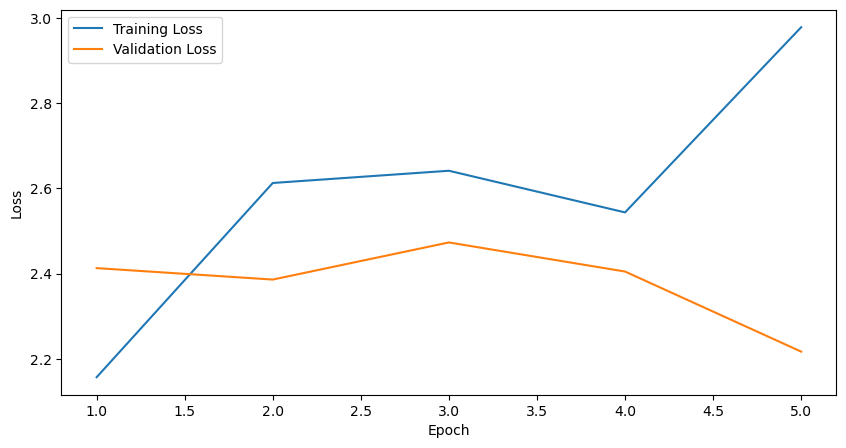

In [45]:
train_model(train_dataloader, valid_dataloader, model, optimizer, scheduler, num_epochs, device)

In [46]:
model.load_state_dict(torch.load("annotated_best_model.pth"))

100%|██████████| 35285/35285 [1:51:19<00:00,  5.28it/s]


<All keys matched successfully>

In [49]:
def generate_text(dataloader, model):
    data = []
    model.eval()

    for batch in dataloader:
        batch = {k:v.type(torch.long).to(device) for k,v in batch.items()}
        input_ids, attention_mask = batch['input_ids'], batch['attention_mask']

        with torch.no_grad():
            generated_texts = model.generate(input_ids, attention_mask=attention_mask,
                                             do_sample=False, max_new_tokens=50, num_return_sequences=1,
                                             eos_token_id=tokenizer.eos_token_id, pad_token_id=tokenizer.pad_token_id
                                             )

            for i, text in enumerate(generated_texts):
                original_text = tokenizer.decode(input_ids[i], skip_special_tokens=True)
                generated_sample = tokenizer.decode(text, skip_special_tokens=True)
                data.append([original_text, generated_sample])

    output_df = pd.DataFrame(data, columns=['original_text', 'generated_sample'])

    return output_df

In [50]:
test_output = generate_text(test_dataloader, model)

In [45]:
ann_output = pd.merge(test_data[['post', 'train_text']], test_output[['generated_sample']], left_index=True, right_index=True)
ann_output.columns = ['post', 'gold', 'predicted']
ann_output.head()

,post,gold,predicted
0,Fuc u say ? &#8220;@AyyyeThatsChubb: All these hoes look good on IG&#8221; http://t.co/PlsFL84cDp,[Worker_-7090297418013232722] [SEP] Fuc u say ? &#8220;@AyyyeThatsChubb: All these hoes look good on IG&#8221; http://t.co/PlsFL84cDp [SEP] [OFF_Y] [SEX_N] [INTENT_Y] [CAT_N] [MIN_N],[Worker_-7090297418013232722] [SEP] Fuc u say? &#8220;@AyyyeThatsChubb: All these hoes look good on IG&#8221; http://t.co/PlsFL84cDp [SEP] [OFF_Y] [SEX_N] [INTENT_Y] [CAT_N] [MIN_N]
1,Fuc u say ? &#8220;@AyyyeThatsChubb: All these hoes look good on IG&#8221; http://t.co/PlsFL84cDp,[Worker_3541686222721437796] [SEP] Fuc u say ? &#8220;@AyyyeThatsChubb: All these hoes look good on IG&#8221; http://t.co/PlsFL84cDp [SEP] [OFF_N] [SEX_N] [INTENT_N] [CAT_N] [MIN_N],[Worker_3541686222721437796] [SEP] Fuc u say? &#8220;@AyyyeThatsChubb: All these hoes look good on IG&#8221; http://t.co/PlsFL84cDp [SEP] [OFF_Y] [SEX_N] [INTENT_Y] [CAT_N] [MIN_N]
2,Fuc u say ? &#8220;@AyyyeThatsChubb: All these hoes look good on IG&#8221; http://t.co/PlsFL84cDp,[Worker_-7353159578349448466] [SEP] Fuc u say ? &#8220;@AyyyeThatsChubb: All these hoes look good on IG&#8221; http://t.co/PlsFL84cDp [SEP] [OFF_Y] [SEX_N] [INTENT_Y] [CAT_N] [MIN_N],[Worker_-7353159578349448466] [SEP] Fuc u say? &#8220;@AyyyeThatsChubb: All these hoes look good on IG&#8221; http://t.co/PlsFL84cDp [SEP] [OFF_Y] [SEX_N] [INTENT_Y] [CAT_N] [MIN_N]
3,Yo hoe is like a tick so she hunting for a blood,[Worker_2430897476320006833] [SEP] Yo hoe is like a tick so she hunting for a blood [SEP] [OFF_Y] [SEX_Y] [INTENT_Y] [CAT_N] [MIN_N],[Worker_2430897476320006833] [SEP] Yo hoe is like a tick so she hunting for a blood [SEP] [OFF_Y] [SEX_N] [INTENT_Y] [CAT_N] [MIN_N]
4,Yo hoe is like a tick so she hunting for a blood,[Worker_-6352039173957003457] [SEP] Yo hoe is like a tick so she hunting for a blood [SEP] [OFF_Y] [SEX_N] [INTENT_Y] [CAT_N] [MIN_N],[Worker_-6352039173957003457] [SEP] Yo hoe is like a tick so she hunting for a blood [SEP] [OFF_Y] [SEX_N] [INTENT_Y] [CAT_N] [MIN_N]


In [46]:
ann_output.to_csv('final_gpt2_sbic_ann_output.csv', index=False)